In [2]:
from keras.preprocessing.image import ImageDataGenerator
from keras import layers, models, callbacks
from keras.utils import load_img, img_to_array
from keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt
import keras
import random
from PIL import Image

In [3]:
import tensorflow as tf
print(tf.__version__)

2.11.0


In [4]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)


Mounted at /content/gdrive


In [5]:
!ls "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images"

test  train  validate


In [6]:
FAST_RUN = False
IMAGE_WIDTH=256
IMAGE_HEIGHT=256
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3
BATCH_SIZE = 32

In [7]:
# Set the directory for the training images
train_dir = '/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/train'
validation_dir = '/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/validate'

In [8]:
# Loop through all image files in the directory
def resize_images(path_to_directory, target_size):
  for filename in os.listdir(path_to_directory):
    if filename.endswith('.jpg') or filename.endswith('.jpeg'):  # Adjust for file extension
      # print(filename)
      # Open the image file
      image = Image.open(os.path.join(path_to_directory, filename))

      # Resize the image
      image = image.resize(target_size)

      # Save the resized image with the same filename
      image.save(os.path.join(path_to_directory, filename))

  print(f"All images resize to {target_size}")

## Resizing the imagaes 

In [9]:
resize_images(os.path.join(train_dir, 'snow'), IMAGE_SIZE)
resize_images(os.path.join(train_dir, 'no_snow'), IMAGE_SIZE)

All images resize to (256, 256)
All images resize to (256, 256)


In [10]:
resize_images(os.path.join(validation_dir, 'snow'), IMAGE_SIZE)
resize_images(os.path.join(validation_dir, 'no_snow'), IMAGE_SIZE)

All images resize to (256, 256)
All images resize to (256, 256)


In [11]:

from keras.preprocessing.image import ImageDataGenerator

# Create an instance of ImageDataGenerator for the validation set
validation_datagen = ImageDataGenerator(
    rescale=1./255,   # Rescale the pixel values to the range [0, 1]
)

# Create an instance of ImageDataGenerator for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,      # Rescale the pixel values to the range [0, 1]
    rotation_range=20,   # Randomly rotate the images by up to 20 degrees
    width_shift_range=0.2,  # Randomly shift the images horizontally by up to 20% of the image width
    height_shift_range=0.2, # Randomly shift the images vertically by up to 20% of the image height
    shear_range=0.2,         # Randomly shear the images by up to 20%
    zoom_range=0.3,          # Randomly zoom the images by up to 20%
    horizontal_flip=True,    # Randomly flip the images horizontally
    vertical_flip=True,
    brightness_range = (0.8, 1.2), # brightness adjuster so that some partial images can detect when ground is dark
    fill_mode='nearest'      # Fill any empty pixels with the nearest available pixel value
)

# Use the flow_from_directory method to load the images from the directory
train_generator = train_datagen.flow_from_directory(
    train_dir,                 # Path to the training set directory
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),    # Resize the images to 256x256
    batch_size=BATCH_SIZE,             # Use batches of 32 images
    class_mode='binary'   # Use categorical cross-entropy loss
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,               # Path to the validation set directory
    target_size=IMAGE_SIZE,    # Resize the images to 256x256
    batch_size=BATCH_SIZE,             # Use batches of 32 images
    class_mode='binary'   # Use categorical cross-entropy loss
)

# Load the training data into x_train and y_train
x_train, y_train = train_generator.next()


Found 2305 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


In [12]:
for BATCH_SIZE, labels_batch in train_generator:
  print(BATCH_SIZE.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


In [13]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 3x3 configuration
nrows = 2
ncols = 2

# Index for iterating over images
pic_index = 0

In [14]:
# Directory with our training all_snow pictures
snow_dir = os.path.join(train_dir + '/snow')

# Directory with our training no_snow pictures
no_snow_dir = os.path.join(train_dir + '/no_snow')


In [15]:
snow_names = random.sample(os.listdir(snow_dir), 10)
print(snow_names[:10])

no_snow_names = random.sample(os.listdir(no_snow_dir), 10)
print(no_snow_names[:10])


['Copy of 2019-03-01_17-06-12_814.jpg', 'Copy of istockphoto-927287364-612x612 (1).jpg', 'Copy of istockphoto-1396694979-612x612 (1).jpg', 'Copy of solar-panel-partially-covered-snow-winter-private-house-210713147.jpg', 'Copy of Copy of OIP32 (1).jpeg', 'Copy of R (7) (1).jpeg', 'Copy of istockphoto-471703490-612x612 (1).jpg', 'Copy of Copy of Copy of o2j247Ig-1200x900 (1).jpeg', 'Copy of istockphoto-873282014-612x612 (1).jpg', 'Copy of istockphoto-1295877242-612x612.jpg']
['images - 2023-03-08T212038.243 (2).jpeg', 'images - 2023-03-08T211852.876 (2).jpeg', 'images (25).jpeg', 'images (222).jpeg', 'images (140).jpeg', 'images - 2023-03-08T211944.926.jpeg', 'Copy of images (22).jpeg', 'images - 2023-03-08T212428.438.jpeg', 'images - 2023-03-08T212504.472 (1).jpeg', 'download (40).jpeg']


In [16]:
snow_cnt = len(os.listdir(snow_dir))
no_snow_cnt = len(os.listdir(no_snow_dir))

print('total training snow images:', snow_cnt)
print('total training no_snow images:', no_snow_cnt)

print(f"total validation snow images: {len(os.listdir(os.path.join(validation_dir, 'snow')))}")
print(f"total validation no_snow images: {len(os.listdir(os.path.join(validation_dir, 'no_snow')))}")


total training snow images: 1201
total training no_snow images: 1151
total validation snow images: 127
total validation no_snow images: 128


In [17]:
from keras.utils import img_to_array

# Load the first example of a image
sample_snow_image  = load_img(f"{os.path.join(snow_dir, os.listdir(snow_dir)[0])}")

# Convert the image into its numpy array representation
sample_snow_array = img_to_array(sample_snow_image)

# Load the first example of a image
sample_nosnow_image  = load_img(f"{os.path.join(no_snow_dir, os.listdir(no_snow_dir)[0])}")

# Convert the image into its numpy array representation
sample_nosnow_array = img_to_array(sample_nosnow_image)

print(f"Each image has shape: {sample_snow_array.shape}")
print(f"The maximum pixel value used is: {np.max(sample_snow_array)}")

print(f"Each image has shape: {sample_nosnow_array.shape}")
print(f"The maximum pixel value used is: {np.max(sample_nosnow_array)}")

Each image has shape: (256, 256, 3)
The maximum pixel value used is: 255.0
Each image has shape: (256, 256, 3)
The maximum pixel value used is: 255.0


In [18]:
if (snow_cnt != no_snow_cnt):
  print('For better training needs same number of images for each category')

For better training needs same number of images for each category


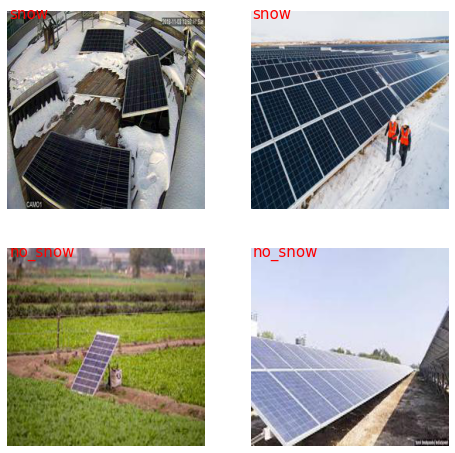

In [19]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 2
next_snow_pix = [os.path.join(snow_dir, fname) 
                for fname in snow_names[pic_index-2:pic_index]]
next_no_snow_pix = [os.path.join(no_snow_dir, fname) 
                for fname in no_snow_names[pic_index-2:pic_index]]

for i, img_path in enumerate(next_snow_pix + next_no_snow_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)
  if i < 2:
    plt.text(2, 10, 'snow', fontsize=15, color='red')
  else:
    plt.text(2, 10, 'no_snow', fontsize=15, color='red')

plt.show()

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

In [20]:
#Build the model

model = models.Sequential([
    # Note the input shape is the desired size of the image 256x256 with 3 bytes color
    # This is the first convolution
    # add the convolutional layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNELS)),
    layers.MaxPooling2D((2, 2)),
    # The second convolution
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The third convolution
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The fourth convolution
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    # The fourth convolution
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),

    # layers.Dropout(0.2),

    # add the fully connected layers
    # Flatten the results to feed into a DNN
    layers.Flatten(),
    # 512 neuron hidden layer
    layers.Dense(512, activation='relu'),
    # 2 output neuron. It will contain a value from 0-1 where 0 for first class ('snow'), 
    # 1 for the second class ('no_snow')
    layers.Dense(1, activation='sigmoid')
])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 128)      0

In [21]:
#Compile model
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

In [22]:
# callback class
class myCallback(callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 90 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('accuracy') > 0.90):

      # Stop if threshold is met
      print("\nAccuracy is higher than 0.90 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [23]:
#Train the model
history = model.fit(
      train_generator,
      steps_per_epoch=len(train_generator),
      epochs=150,
      validation_data=validation_generator,
      validation_steps=3,
      verbose=2,
      callbacks=[callbacks]
)

Epoch 1/150
73/73 - 60s - loss: 0.6923 - accuracy: 0.5401 - val_loss: 0.6846 - val_accuracy: 0.4792 - 60s/epoch - 823ms/step
Epoch 2/150
73/73 - 58s - loss: 0.6457 - accuracy: 0.6343 - val_loss: 0.7605 - val_accuracy: 0.5625 - 58s/epoch - 791ms/step
Epoch 3/150
73/73 - 58s - loss: 0.5877 - accuracy: 0.6998 - val_loss: 0.4855 - val_accuracy: 0.8646 - 58s/epoch - 790ms/step
Epoch 4/150
73/73 - 58s - loss: 0.5403 - accuracy: 0.7414 - val_loss: 0.3702 - val_accuracy: 0.8958 - 58s/epoch - 792ms/step
Epoch 5/150
73/73 - 58s - loss: 0.4922 - accuracy: 0.7731 - val_loss: 0.3554 - val_accuracy: 0.8438 - 58s/epoch - 789ms/step
Epoch 6/150
73/73 - 58s - loss: 0.4614 - accuracy: 0.7931 - val_loss: 0.3375 - val_accuracy: 0.8854 - 58s/epoch - 795ms/step
Epoch 7/150
73/73 - 57s - loss: 0.4446 - accuracy: 0.7905 - val_loss: 0.3296 - val_accuracy: 0.8542 - 57s/epoch - 784ms/step
Epoch 8/150
73/73 - 57s - loss: 0.4153 - accuracy: 0.8182 - val_loss: 0.2640 - val_accuracy: 0.8646 - 57s/epoch - 784ms/step


In [24]:
# Evaluate the model on the validation data
loss, accuracy = model.evaluate(validation_generator, steps=len(validation_generator))

print('Validation loss:', loss)
print('Validation accuracy:', accuracy)


8/8 [==============================] - 1s 137ms/step - loss: 0.2415 - accuracy: 0.9083
Validation loss: 0.24150684475898743
Validation accuracy: 0.9083333611488342


In [25]:
class_dict = {0: "snow", 1: "no_snow"}


1/1 [==============================] - 0s 31ms/step


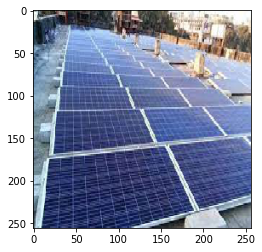

[0.00730216]
nosnow1.jpeg is no_snow


In [104]:

# uploaded = files.upload()

# for fn in uploaded.keys():
 
# predicting images
current_dir = os.getcwd()
fn = "nosnow1.jpeg"
path = os.path.join('/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/test/no_snow/', fn)
img = load_img(path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print(fn + " is snow")
else:
    print(fn + " is no_snow")

1/1 [==============================] - 0s 29ms/step


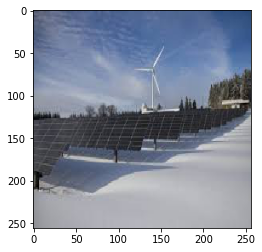

[0.98889816]
groundsnow2.jpeg is snow


In [108]:

# uploaded = files.upload()

# for fn in uploaded.keys():
 
# predicting images
current_dir = os.getcwd()
fn = "groundsnow2.jpeg"
path = os.path.join('/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/test/snow/', fn)
img = load_img(path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print(fn + " is snow")
else:
    print(fn + " is no_snow")

1/1 [==============================] - 0s 29ms/step


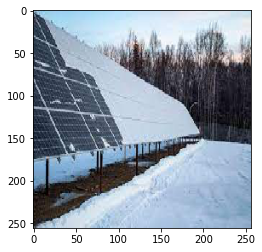

[0.9975176]
partialsnow1.jpeg is snow


In [107]:

# uploaded = files.upload()

# for fn in uploaded.keys():
 
# predicting images
current_dir = os.getcwd()
fn = "partialsnow1.jpeg"
path = os.path.join('/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/test/snow/', fn)
img = load_img(path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print(fn + " is snow")
else:
    print(fn + " is no_snow")

1/1 [==============================] - 0s 27ms/step


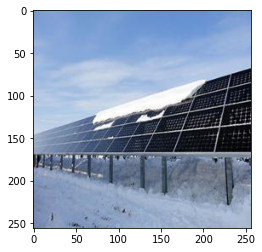

[0.99824077]
nosnow1.jpeg is snow


In [27]:
# from keras.preprocessing.image import load_img, img_to_array

img_path = '/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/validate/snow/Copy of msbtnb_zu03_s.jpg'

img = load_img(img_path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print(fn + " is snow")
else:
    print(fn + " is no_snow")



In [28]:
# Save the trained model
model.save('snow_detection_model.h5')

In [29]:
import shutil
shutil.copy('snow_detection_model.h5','gdrive/MyDrive/models/snow_detection_model.h5')

'gdrive/MyDrive/models/snow_detection_model.h5'

In [30]:
# Load the saved model
loaded_model = models.load_model('gdrive/MyDrive/models/snow_detection_model.h5')

1/1 [==============================] - 0s 28ms/step


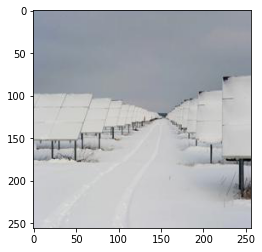

[0.9615906]
snow


In [31]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/validate/snow/Copy of Copy of bfd7f1d666fd3430f9bb513dd3ae5acd.jpg"

img = load_img(img_path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print("snow")
else:
    print("no_snow")

1/1 [==============================] - 0s 27ms/step


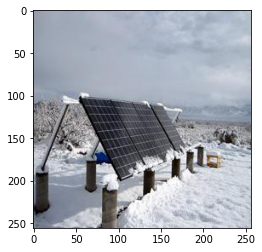

[0.9923366]
snow


In [32]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/validate/snow/Copy of 4209417545_ee945518e5.jpg"

img = load_img(img_path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print("snow")
else:
    print("no_snow")

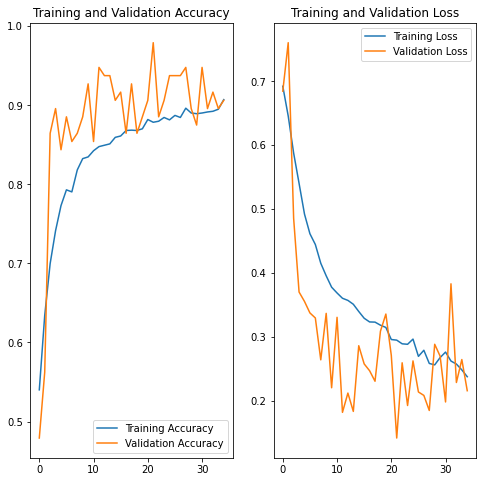

In [33]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 0s 28ms/step


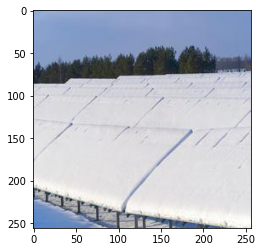

[0.99823886]
snow


In [34]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/validate/snow/Copy of Copy of Copy of solar-panel-field-covered-snow-renewable-energy-winter-low-efficiency-green-industry-concept-time-photovoltaic-modules-226728230.jpg"

img = load_img(img_path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print("snow")
else:
    print("no_snow")

1/1 [==============================] - 0s 28ms/step


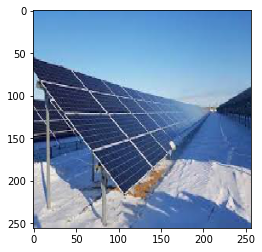

[0.8918974]
groundsnow2.jpeg is snow


In [110]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/test/snow/groundsnow4.jpeg"

img = load_img(img_path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print(fn + " is snow")
else:
    print(fn + " is no_snow")

1/1 [==============================] - 0s 28ms/step


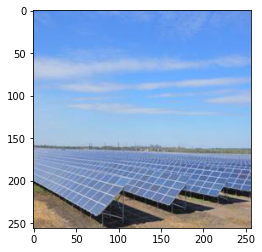

[0.00161168]
no_snow


In [36]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/validate/no_snow/Copy of 0.32518800_1466691374_solar-power-plant.jpg"

img = load_img(img_path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print("snow")
else:
    print("no_snow")

1/1 [==============================] - 0s 27ms/step


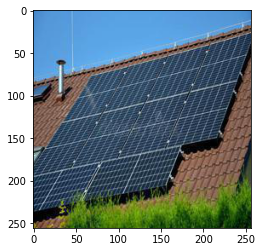

[0.00019556]
no_snow


In [37]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/validate/no_snow/Copy of Copy of photovoltaic-home-solar-panels-work-sunny-snow-low-temperatures-performance-decreases-exponentially-255444591.jpg"

img = load_img(img_path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print("snow")
else:
    print("no_snow")

1/1 [==============================] - 0s 28ms/step


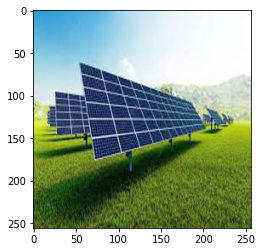

[7.366162e-05]
no_snow


In [38]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np

# img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/test/no_snow/nosnow5.jpeg"
img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/train/no_snow/images (311).jpeg"

img = load_img(img_path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print("snow")
else:
    print("no_snow")

1/1 [==============================] - 0s 29ms/step


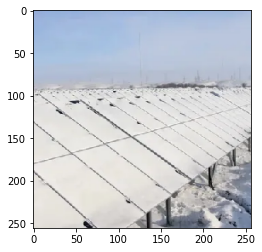

[0.98897433]
snow


In [39]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/validate/snow/Copy of snow_on_solar_10.jpg.webp"

img = load_img(img_path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print("snow")
else:
    print("no_snow")

1/1 [==============================] - 0s 31ms/step


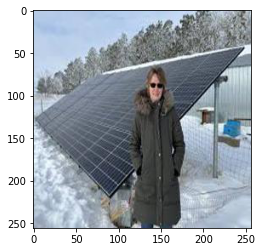

[0.9403332]
snow


In [40]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np

img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/validate/snow/Copy of images (11).jpeg"

img = load_img(img_path, target_size=IMAGE_SIZE)
x = img_to_array(img)
x /= 255
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict(images, batch_size=10)
# Show image
plt.imshow(img)
plt.show()
print(classes[0])
if classes[0]>0.5:
    print("snow")
else:
    print("no_snow")

1/1 [==============================] - 0s 104ms/step
4
4
4
4
4
4


<ipython-input-41-4796e3fb0af0>:49: RuntimeWarning: invalid value encountered in divide
  x /= x.std()
<ipython-input-41-4796e3fb0af0>:52: RuntimeWarning: invalid value encountered in cast
  x = np.clip(x, 0, 255).astype('uint8')


4
4
4
2
2
2


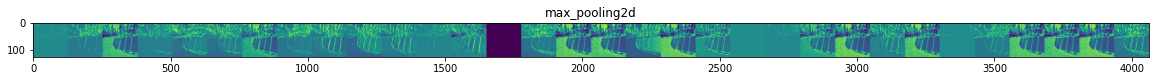

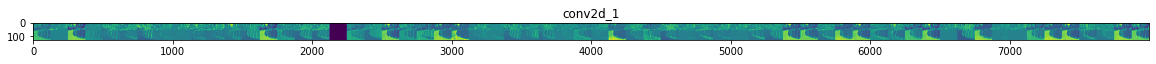

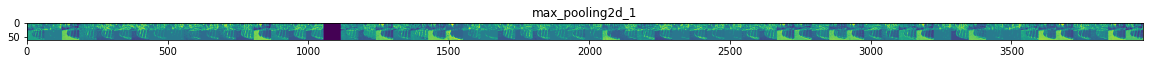

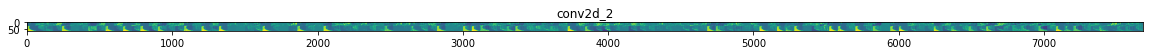

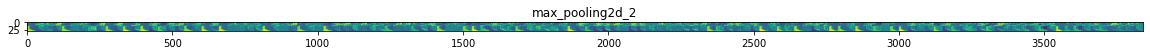

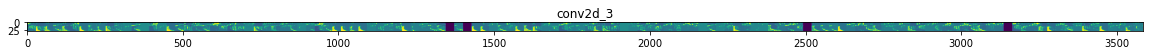

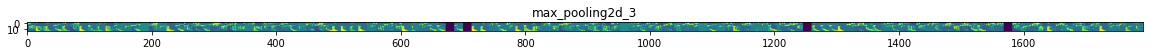

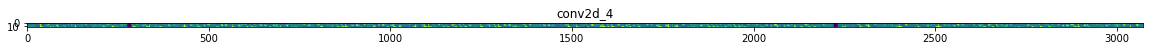

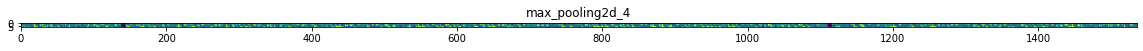

In [41]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import random
from keras.utils import img_to_array, load_img
from keras.models import Model

# Define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
visualization_model = Model(inputs = model.input, outputs = successive_outputs)

# Prepare a random input image from the training set.
snow_img_files = [os.path.join(snow_dir, f) for f in snow_names]
no_snow_img_files = [os.path.join(no_snow_dir, f) for f in no_snow_names]
img_path = random.choice(snow_img_files + no_snow_img_files)
img = load_img(img_path, target_size=(256, 256))  
x = img_to_array(img)  # Numpy array with shape (256, 256, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 256, 256, 3)

# Scale by 1/255
x /= 255

# Run the image through the network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so you can have them as part of the plot
layer_names = [layer.name for layer in model.layers[1:]]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  print(len(feature_map.shape))
  if len(feature_map.shape) == 4:

    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map

    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    
    # Tile the images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
    
      # Tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [175]:
import tensorflow as tf

# Convert the model
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()


In [176]:
# Save the model.
with open('snow_nosnow_detect_model.tflite', 'wb') as f:
  f.write(tflite_model)

shutil.copy('snow_nosnow_detect_model.tflite','gdrive/MyDrive/models/snow_nosnow_detect_model.tflite')

'gdrive/MyDrive/models/snow_nosnow_detect_model.tflite'

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [196]:
TF_MODEL_FILE_PATH = 'gdrive/MyDrive/models/snow_nosnow_detect_model.tflite' # The default path to the saved TensorFlow Lite model


In [198]:
class_dict = {0: "snow", 1: "no_snow"}

In [199]:
size=(256, 256)

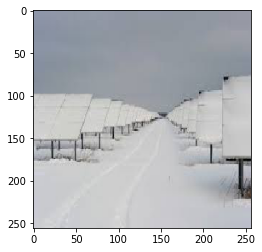

[[0.95978045]]
1
snow


In [200]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np
import cv2

# img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/test/no_snow/nosnow3.jpeg"
img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/test/snow/allsnow3.jpeg"
# img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/validate/snow/Copy of images (11).jpeg"

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
signature = interpreter.get_signature_list()

# Load and preprocess your image
img = load_img(img_path, target_size=size)

# Show image
plt.imshow(img)
plt.show()

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
img = Image.open(img_path)
img = img.resize(size)
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
# Convert the data type of the input tensor to FLOAT32
img_array = tf.cast(img_array, tf.float32)
# print(signature)

# input_shape = input_details[0]['shape']
# input_data = np.array(img, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], img_array)

# interpreter = tf.lite.Interpreter(model_path=tf_model_file)
# interpreter.allocate_tensors()
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

prediction = 1 if output_data > 0.5 else 0
print(prediction)
if prediction == 0:
    predicted_label = class_dict[1]
else:
    predicted_label = class_dict[0]

print(predicted_label)
 

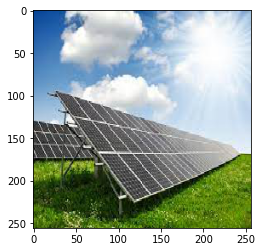

[[0.00023762]]
0
no_snow


In [202]:
# from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array
import numpy as np
import copy

img_path = "/content/gdrive/MyDrive/Snow_Covered_Solar_Panel_Detect/snow_and_nosnow_images/test/no_snow/nosnow3.jpeg"

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
signature = interpreter.get_signature_list()

# Load and preprocess your image
img = load_img(img_path, target_size=size)

# Show image
plt.imshow(img)
plt.show()

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Load and preprocess the image
img = Image.open(img_path)
img = img.resize(size)
img_array = np.array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)
# Convert the data type of the input tensor to FLOAT32
img_array = tf.cast(img_array, tf.float32)
# print(signature)

# input_shape = input_details[0]['shape']
# input_data = np.array(img, dtype=np.float32)
interpreter.set_tensor(input_details[0]['index'], img_array)

# interpreter = tf.lite.Interpreter(model_path=tf_model_file)
# interpreter.allocate_tensors()
interpreter.invoke()

output_data = interpreter.get_tensor(output_details[0]['index'])
print(output_data)

prediction = 1 if output_data > 0.5 else 0
print(prediction)
if prediction == 0:
    predicted_label = class_dict[1]
else:
    predicted_label = class_dict[0]

print(predicted_label)